In [684]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lxml
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from datetime import timedelta

from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

kw_list = ['hedge','profit','metals','nasdaq','stocks']
pytrends.build_payload(kw_list, cat=0, timeframe='2018-01-01 2018-12-31', geo='US', gprop='')
trend_data = pytrends.interest_over_time()

days = pd.date_range('2018-01-01', '2018-12-31')
trend_data_daily = pd.DataFrame({'Index':days})
trend_data_daily.set_index('Index', inplace = True)
print(trend_data.head())




#djia_data.head()
#plt.plot(djia_data.Date, djia_data.Diff)


            hedge  profit  metals  nasdaq  stocks  isPartial
date                                                        
2018-01-07     17      40      22      15      85      False
2018-01-14     16      40      23      14      72      False
2018-01-21     17      47      25      17      79      False
2018-01-28     18      46      24      17      83      False
2018-02-04     18      45      24      28     100      False


In [647]:
trend_merged = trend_data_daily.merge(trend_data, how = 'left', left_index = True, right_index = True )
trend_merged['hedge'].interpolate(method = 'linear', inplace = True)
trend_merged['profit'].interpolate(method = 'linear', inplace = True)
trend_merged['metals'].interpolate(method = 'linear', inplace = True)
trend_merged['nasdaq'].interpolate(method = 'linear', inplace = True)
trend_merged['stocks'].interpolate(method = 'linear', inplace = True)
trend_merged['s1'] = trend_merged['hedge'] ** 2
trend_merged['s2'] = trend_merged['profit'] ** 2
trend_merged['s3'] = trend_merged['metals'] ** 2
trend_merged['s4'] = trend_merged['nasdaq'] ** 2
trend_merged['s5'] = trend_merged['stocks'] ** 2
print(trend_merged.head())

            hedge  profit  metals  nasdaq  stocks isPartial  s1  s2  s3  s4  \
Index                                                                         
2018-01-01    NaN     NaN     NaN     NaN     NaN       NaN NaN NaN NaN NaN   
2018-01-02    NaN     NaN     NaN     NaN     NaN       NaN NaN NaN NaN NaN   
2018-01-03    NaN     NaN     NaN     NaN     NaN       NaN NaN NaN NaN NaN   
2018-01-04    NaN     NaN     NaN     NaN     NaN       NaN NaN NaN NaN NaN   
2018-01-05    NaN     NaN     NaN     NaN     NaN       NaN NaN NaN NaN NaN   

            s5  
Index           
2018-01-01 NaN  
2018-01-02 NaN  
2018-01-03 NaN  
2018-01-04 NaN  
2018-01-05 NaN  


In [728]:
djia_data = pd.read_csv('DJI.csv', usecols=['Date', 'Close'])
djia_data.Date = pd.to_datetime(djia_data.Date)
print(djia_data.dtypes)

days = pd.date_range('2018-01-01', '2019-02-15')
djia_data_daily = pd.DataFrame({'Index':days})
djia_data_daily.set_index('Index', inplace = True)
djia_merged = djia_data_daily.merge(djia_data, how = 'left', left_index = True, right_on = 'Date' )


djia_merged.reset_index(inplace = True, drop = True)
djia_merged.set_index('Date', inplace = True)
djia_merged['Close'].interpolate(method = 'linear', inplace = True)
print(djia_merged.dtypes)
print(' ')
print(trend_merged.dtypes)
trend_djia_merged = trend_merged.merge(djia_merged, how = 'left', left_index = True, right_index = True)


diff_period = 46
trend_djia_merged['Diff'] = trend_djia_merged['Close'].diff(periods=diff_period).shift(-diff_period)
trend_djia_merged['timestamp'] = range(0, len(trend_djia_merged))
print(trend_djia_merged.tail())

Date     datetime64[ns]
Close           float64
dtype: object
Close    float64
dtype: object
 
hedge        float64
profit       float64
metals       float64
nasdaq       float64
stocks       float64
isPartial     object
s1           float64
s2           float64
s3           float64
s4           float64
s5           float64
dtype: object
                hedge     profit     metals     nasdaq  stocks isPartial  \
Index                                                                      
2018-12-27  14.428571  26.428571  14.714286  17.714286    62.0       NaN   
2018-12-28  14.285714  27.285714  15.142857  17.142857    61.0       NaN   
2018-12-29  14.142857  28.142857  15.571429  16.571429    60.0       NaN   
2018-12-30  14.000000  29.000000  16.000000  16.000000    59.0     False   
2018-12-31  14.000000  29.000000  16.000000  16.000000    59.0       NaN   

                    s1          s2          s3          s4      s5  \
Index                                                    

Text(0, 0.5, 'difference between current DJI value and value from 6 weeks later')

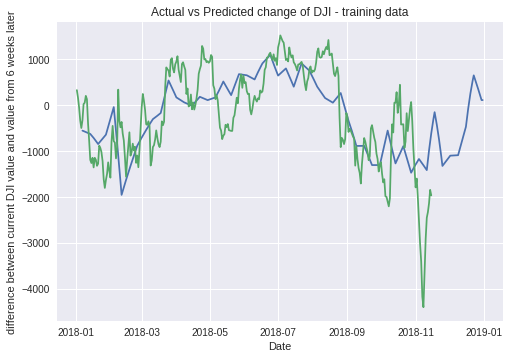

In [745]:
X = trend_djia_merged[['s1','s3','nasdaq']]
y = trend_djia_merged['Diff']

X = sm.add_constant(X)
est = sm.OLS(y, X, missing='drop').fit()
#print(est.summary())

trend_djia_merged['pd'] = est.predict(X)
plt.plot(trend_djia_merged['pd'])
plt.plot(trend_djia_merged['Diff'])
plt.title("Actual vs Predicted change of DJI - training data")
plt.xlabel('Date')
plt.ylabel('difference between current DJI value and value from 6 weeks later')

pd                      float64
newtime          datetime64[ns]
mean                    float64
mean_se                 float64
mean_ci_lower           float64
mean_ci_upper           float64
obs_ci_lower            float64
obs_ci_upper            float64
Close                   float64
pd_lower                float64
pd_upper                float64
dtype: object


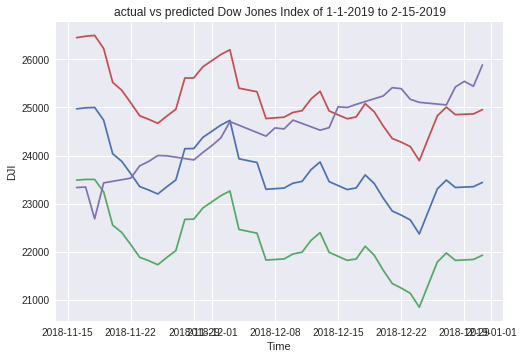

In [751]:
trend_djia_merged['pd'] = est.predict(X)
aaa = est.get_prediction(X)
ci = aaa.summary_frame(alpha = 0.05)
days = pd.date_range('2018-11-16', '2018-12-31')
prediction = pd.DataFrame({'Index':days})
prediction.set_index('Index', inplace = True)

prediction['pd'] = trend_djia_merged['Close'] + trend_djia_merged['pd']
prediction['newtime'] = prediction.index + timedelta(days = 46)

prediction_x = prediction.merge(ci, how = 'left',  left_index = True, right_index = True)
prediction_final = prediction_x.merge(djia_merged, how = 'left',  left_on = 'newtime', right_index = True)
prediction_final['pd_lower'] = trend_djia_merged['Close'] + prediction_x['obs_ci_lower']
prediction_final['pd_upper'] = trend_djia_merged['Close'] + prediction_x['obs_ci_upper']
print(prediction_final.dtypes)
plt.plot(prediction_final['pd'])
plt.plot(prediction_final['pd_lower'])
plt.plot(prediction_final['pd_upper'])
plt.plot(prediction_final['Close'])
plt.title('actual vs predicted Dow Jones Index of 1-1-2019 to 2-15-2019')
plt.xlabel('Time')
plt.ylabel('DJI')

prediction_final.to_csv(r'dji_prediction.csv')